In [1]:
!pip install git+https://github.com/samoturk/mol2vec;

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-l2g1rh7w
  Running command git clone --filter=blob:none --quiet https://github.com/samoturk/mol2vec /tmp/pip-req-build-l2g1rh7w
  Resolved https://github.com/samoturk/mol2vec to commit 850d944d5f48a58e26ed0264332b5741f72555aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 8.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.6 MB/s eta 0:00:00
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14015 sha256=f4bea827f781c223a13164a9ac4040e5eeb93e8d7328af89d35e638fde21ff71
  Stored in directory: /tmp/pip-ephem-wheel-cache-f51jlr16/wheels/80/d5/e1/90dc211e4a17780f99eaec43328470a70284cd731ef2a77034
Successfully built mol2vec


In [14]:
!pip install gensim==3.7.1

  Using cached gensim-3.7.1-cp37-cp37m-manylinux1_x86_64.whl (24.2 MB)


In [1]:
import gensim
print(gensim.__version__) # 3.7.1

3.7.1


In [4]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
import pandas as pd
from rdkit import Chem
from mol2vec.features import MolSentence, DfVec, sentences2vec, mol2alt_sentence, mol2sentence
from gensim.models import word2vec
import numpy as np
import matplotlib.pyplot as plt
from utils import SMILES2Wec

directory = './materials/'
preprocessor = SMILES2Wec(directory)
mdf = preprocessor.load_data("train_data_fix_concat.csv")
mdf = preprocessor.preprocess_data(mdf)
grouped_mdf = preprocessor.preprocess_mol2vec(mdf)
smiles_df = preprocessor.smiles2sentences(mdf)
joined_df = pd.merge(grouped_mdf, smiles_df, on='blend_id', how='inner')

X, y = preprocessor.xy_split(joined_df)

In [6]:
print(y.shape)
print(X.shape)

(338,)
(338, 300)


/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.341e+09, tolerance: 2.134e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.015e+09, tolerance: 2.134e+08
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of

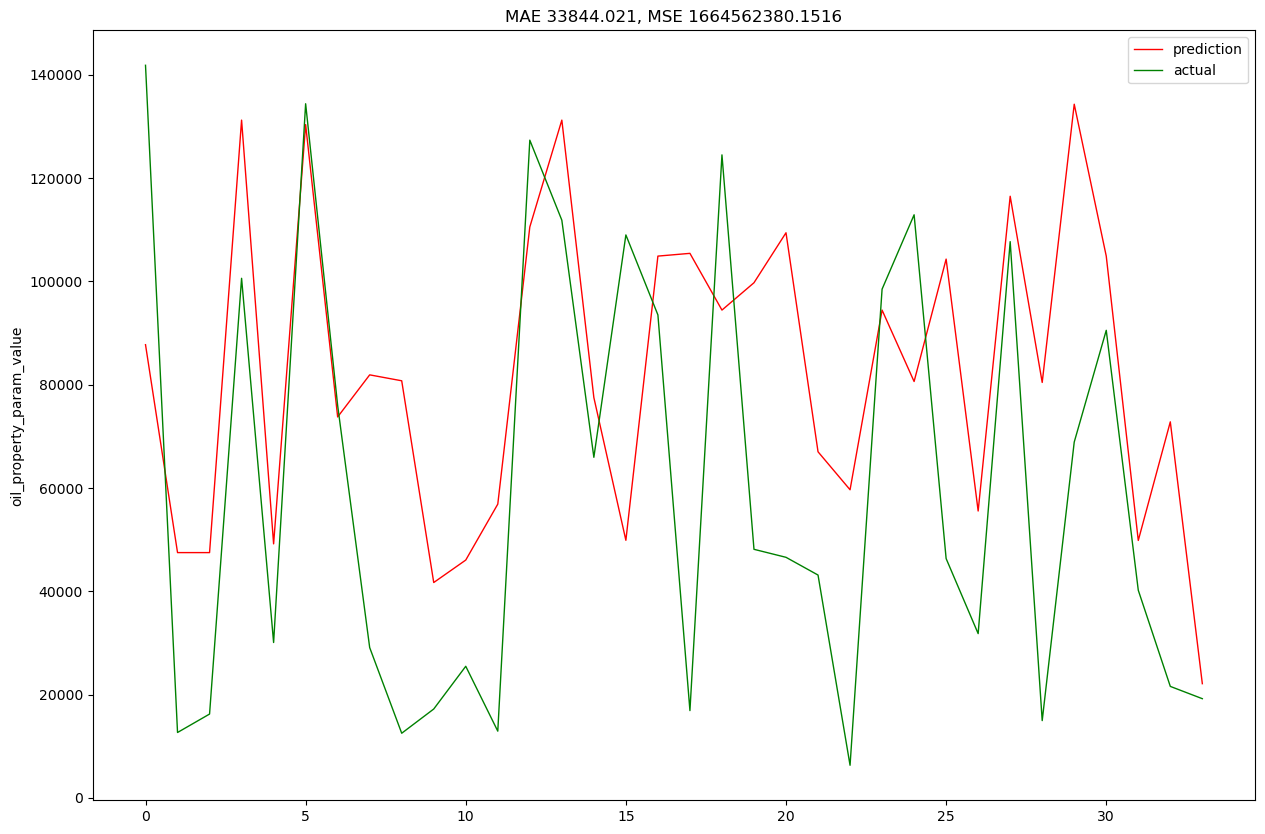

MAE score: 33844.021
MSE score: 1664562380.1516


In [7]:
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('oil_property_param_value')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('MSE score:', round(mse,4))
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
evaluation(lasso, X_test, y_test)

/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.97524e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=4.99949e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.30529e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/karnaksp/miniconda3/envs/myenv/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=6.63146e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, ove

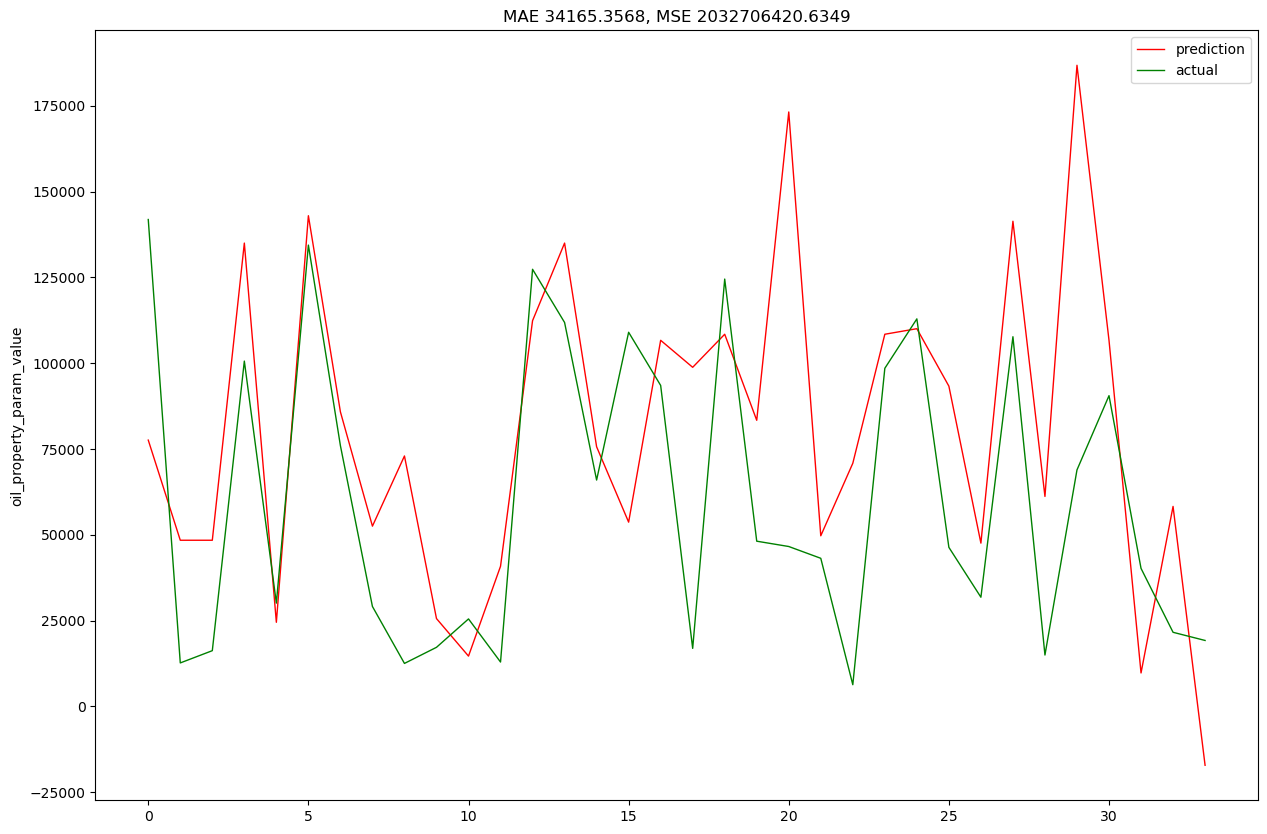

MAE score: 34165.3568
MSE score: 2032706420.6349


In [8]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
evaluation(ridge, X_test, y_test)

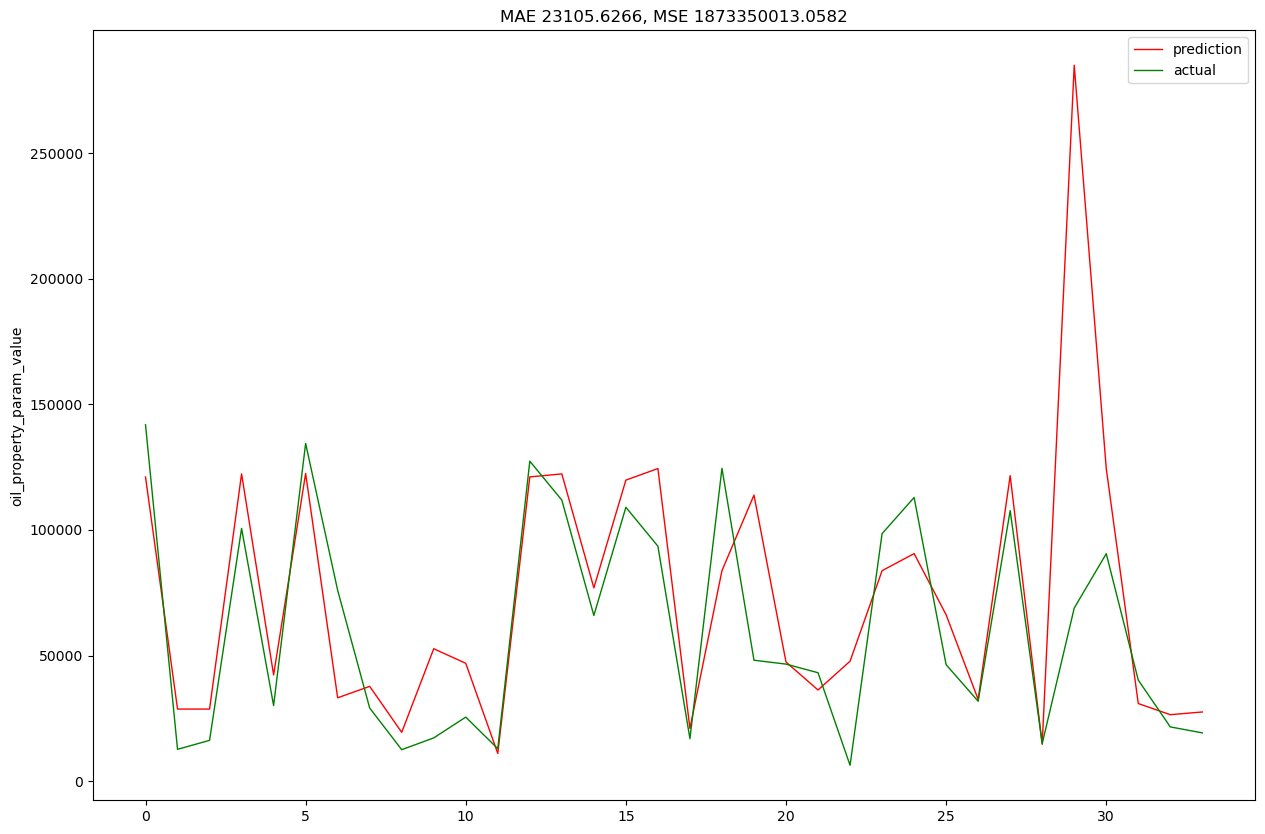

MAE score: 23105.6266
MSE score: 1873350013.0582


In [9]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
evaluation(rf, X_test, y_test)

0:	learn: 84656.8678514	test: 44438.3415898	best: 44438.3415898 (0)	total: 106ms	remaining: 1m 46s
100:	learn: 41113.5148313	test: 41620.6508226	best: 40131.5895355 (9)	total: 2.31s	remaining: 20.6s
200:	learn: 39991.2774528	test: 41919.9691687	best: 40131.5895355 (9)	total: 4.21s	remaining: 16.7s
300:	learn: 39907.9418911	test: 42131.4189958	best: 40131.5895355 (9)	total: 5.88s	remaining: 13.7s
400:	learn: 39900.9296192	test: 42261.1896594	best: 40131.5895355 (9)	total: 7.77s	remaining: 11.6s
500:	learn: 39900.0592485	test: 42284.2639951	best: 40131.5895355 (9)	total: 10s	remaining: 10s
600:	learn: 39899.9090610	test: 42288.8434850	best: 40131.5895355 (9)	total: 12.5s	remaining: 8.31s
700:	learn: 39899.8603486	test: 42292.1454239	best: 40131.5895355 (9)	total: 15s	remaining: 6.38s
800:	learn: 39899.8445999	test: 42294.5901269	best: 40131.5895355 (9)	total: 17.3s	remaining: 4.31s
900:	learn: 39899.8386028	test: 42295.7010030	best: 40131.5895355 (9)	total: 19.8s	remaining: 2.18s
999:	le

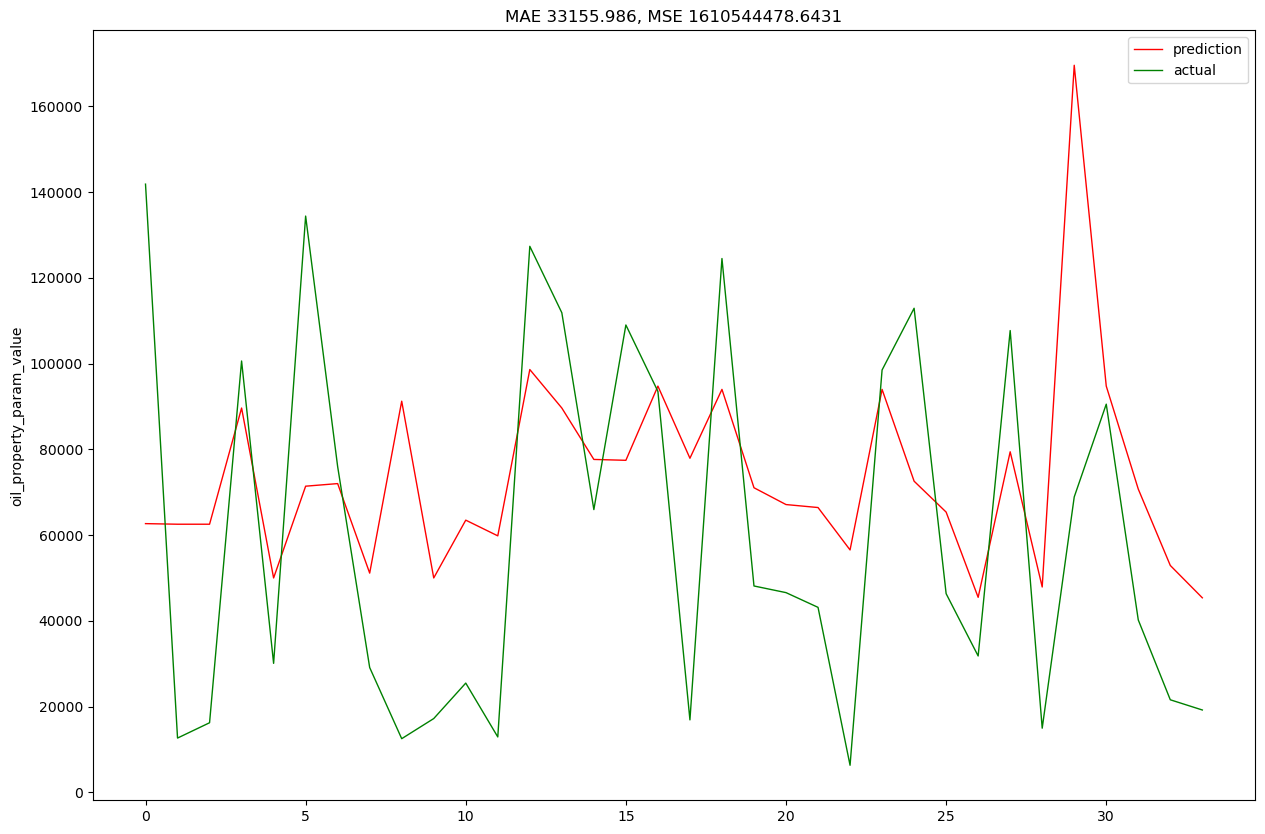

MAE score: 33155.986
MSE score: 1610544478.6431


In [10]:
catboost = CatBoostRegressor(iterations=1000, learning_rate=0.1, loss_function='RMSE', random_seed=1)
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=100)
evaluation(catboost, X_test, y_test)


In [15]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from rdkit import Chem  # To extract information of the molecules
from rdkit.Chem import Draw  # To draw the molecules
from mordred import Calculator, descriptors  # To calculate descriptors
from molml.features import CoulombMatrix  # To calculate the coulomb matrix
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

def neural_model(x, y, x_test, y_test, neurons):
    np.random.seed(1)
    score = []
    kfold = KFold(n_splits=5, shuffle=True)
    
    model = Sequential()
    model.add(Dense(neurons, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='linear'))

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['mean_absolute_error'])

    rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=10)
        
    for train, validation in kfold.split(x, y):

        model.fit(x[train], y[train], 
                      epochs=100,
                      batch_size=128,
                      callbacks=[rlrop],
                      verbose=0,
                      validation_data=(x[validation], y[validation]))

        score.append(model.evaluate(x_test, y_test))
    
    return model, score


In [16]:
model, score = neural_model(X_train, y_train, X_test, y_test, neurons=64)

2/2 [==============================] - 0s 6ms/step - loss: 2199502080.0000 - mean_absolute_error: 38980.4492


In [18]:
# evaluation(neural_model, X_test, y_test)